In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [5]:
train_path = '/content/drive/MyDrive/swarm/data/train_val.data'
test_path  = '/content/drive/MyDrive/swarm/data/test.data'

cols = [f'f{i}' for i in range(30)] + ['label']

train_df = pd.read_csv(train_path, header=None, names=cols)
test_df  = pd.read_csv(test_path, header=None, names=cols)

In [6]:
def preprocess_train(df):
    X = df.iloc[:, :-1].values.astype(float)
    y = df.iloc[:, -1].map({'M':1, 'B':-1}).values

    X_min = X.min(axis=0)
    X_max = X.max(axis=0)

    X = (X - X_min) / (X_max - X_min + 1e-8)
    return X, y, X_min, X_max


def preprocess_test(df, X_min, X_max):
    X = df.iloc[:, :-1].values.astype(float)
    y = df.iloc[:, -1].map({'M':1, 'B':-1}).values

    X = (X - X_min) / (X_max - X_min + 1e-8)
    return X, y

In [7]:
def train_val_split(X, y, val_ratio=0.2):
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    split = int(len(X)*(1-val_ratio))

    return X[idx[:split]], X[idx[split:]], y[idx[:split]], y[idx[split:]]

In [8]:
X_all, y_all, X_min, X_max = preprocess_train(train_df)
X_test, y_test = preprocess_test(test_df, X_min, X_max)

X_train, X_val, y_train, y_val = train_val_split(X_all, y_all)

print(X_train.shape, X_val.shape, X_test.shape)

(364, 30) (91, 30) (114, 30)


In [9]:
def rbf_kernel(X1, X2, gamma):
    K = np.zeros((X1.shape[0], X2.shape[0]))
    for i in range(X1.shape[0]):
        for j in range(X2.shape[0]):
            diff = X1[i] - X2[j]
            K[i, j] = np.exp(-gamma * np.dot(diff, diff))
    return K

In [10]:
class RBFSVM:
    def __init__(self, C, gamma):
        self.C = C
        self.gamma = gamma
        self.epoch_history = []

    def fit(self, X, y, epochs=20, lr=0.01):
        n = X.shape[0]
        self.X = X
        self.y = y
        self.alpha = np.zeros(n)

        K = rbf_kernel(X, X, self.gamma)

        for ep in range(epochs):
            for i in range(n):
                margin = np.sum(self.alpha * y * K[:, i])
                if y[i] * margin < 1:
                    self.alpha[i] += lr * (1 - y[i] * margin)
                self.alpha[i] = np.clip(self.alpha[i], 0, self.C)

            # === evaluasi training acc per epoch ===
            pred = self.predict(X)
            acc = np.mean(pred == y)
            self.epoch_history.append(acc)

    def predict(self, X):
        K = rbf_kernel(self.X, X, self.gamma)
        decision = np.dot((self.alpha * self.y), K)
        return np.where(decision >= 0, 1, -1)

In [11]:
baseline_C = 1.0
baseline_gamma = 1.0

svm_baseline = RBFSVM(baseline_C, baseline_gamma)
svm_baseline.fit(X_train, y_train, epochs=50)

# validation accuracy
val_pred = svm_baseline.predict(X_val)
val_acc = np.mean(val_pred == y_val)
print("Baseline SVM Validation Accuracy:", val_acc)

print("\nSVM Epoch Progress")
print("-"*45)
for i, acc in enumerate(svm_baseline.epoch_history, 1):
    bar = "█" * int(acc * 50)
    print(f"Epoch {i:02d} | Acc: {acc:.4f} | {bar}")

Baseline SVM Validation Accuracy: 0.978021978021978

SVM Epoch Progress
---------------------------------------------
Epoch 01 | Acc: 0.9121 | █████████████████████████████████████████████
Epoch 02 | Acc: 0.9423 | ███████████████████████████████████████████████
Epoch 03 | Acc: 0.9533 | ███████████████████████████████████████████████
Epoch 04 | Acc: 0.9505 | ███████████████████████████████████████████████
Epoch 05 | Acc: 0.9533 | ███████████████████████████████████████████████
Epoch 06 | Acc: 0.9560 | ███████████████████████████████████████████████
Epoch 07 | Acc: 0.9588 | ███████████████████████████████████████████████
Epoch 08 | Acc: 0.9615 | ████████████████████████████████████████████████
Epoch 09 | Acc: 0.9643 | ████████████████████████████████████████████████
Epoch 10 | Acc: 0.9670 | ████████████████████████████████████████████████
Epoch 11 | Acc: 0.9670 | ████████████████████████████████████████████████
Epoch 12 | Acc: 0.9670 | ████████████████████████████████████████████████
Epo

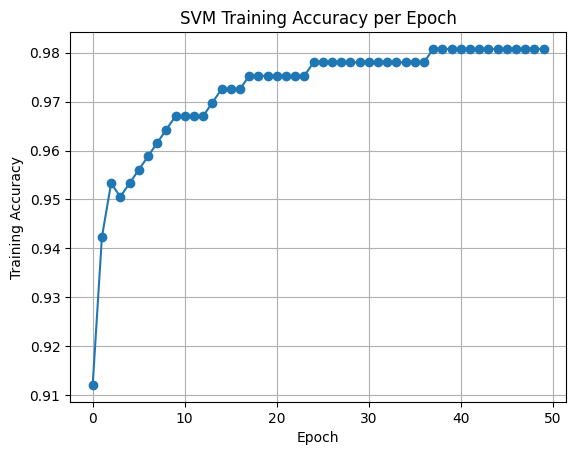

In [12]:
# === GRAFIK ===
plt.plot(svm_baseline.epoch_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("SVM Training Accuracy per Epoch")
plt.grid()
plt.show()

In [13]:
def fitness(position):
    C, gamma = position

    svm = RBFSVM(C, gamma)
    svm.fit(X_train, y_train, epochs=5)

    pred = svm.predict(X_val)
    acc = np.mean(pred == y_val)

    noise = np.random.uniform(0, 0.001)
    penalty = 1e-4 * (C + gamma)

    return acc + noise - penalty

In [14]:
class GWO:
    def __init__(self, n_wolves=8, max_iter=50):
        self.n_wolves = n_wolves
        self.max_iter = max_iter
        self.lb = np.array([0.1, 0.01])     # C, gamma
        self.ub = np.array([100, 10])
        self.history = []

    def optimize(self):
        wolves = np.random.uniform(self.lb, self.ub, (self.n_wolves, 2))

        for t in range(self.max_iter):
            scores = np.array([fitness(w) for w in wolves])
            idx = scores.argsort()[::-1]

            alpha, beta, delta = wolves[idx[:3]]
            best_score = scores[idx[0]]
            self.history.append(best_score)

            a = 2 - 2*t/self.max_iter

            for i in range(self.n_wolves):
                for d in range(2):
                    r1, r2 = random.random(), random.random()
                    A = 2*a*r1 - a
                    Cc = 2*r2

                    D = abs(Cc*alpha[d] - wolves[i][d])
                    wolves[i][d] = alpha[d] - A*D

                wolves[i] = np.clip(wolves[i], self.lb, self.ub)

            print(
                f"Iter {t+1} | "
                f"Best Fitness: {best_score:.4f} | "
                f"C={alpha[0]:.3f}, Gamma={alpha[1]:.3f}"
            )
        return alpha

In [15]:
gwo = GWO()
best_params = gwo.optimize()

best_C, best_gamma = best_params
print("Best C:", best_C)
print("Best Gamma:", best_gamma)

final_svm = RBFSVM(best_C, best_gamma)
final_svm.fit(X_all, y_all, epochs=50)

Iter 1 | Best Fitness: 0.9560 | C=3.446, Gamma=2.706
Iter 2 | Best Fitness: 0.9562 | C=0.100, Gamma=2.485
Iter 3 | Best Fitness: 0.9563 | C=0.100, Gamma=4.261
Iter 4 | Best Fitness: 0.9666 | C=0.105, Gamma=10.000
Iter 5 | Best Fitness: 0.9669 | C=0.107, Gamma=10.000
Iter 6 | Best Fitness: 0.9670 | C=0.131, Gamma=10.000
Iter 7 | Best Fitness: 0.9670 | C=0.100, Gamma=10.000
Iter 8 | Best Fitness: 0.9669 | C=0.165, Gamma=7.701
Iter 9 | Best Fitness: 0.9669 | C=0.100, Gamma=10.000
Iter 10 | Best Fitness: 0.9668 | C=0.100, Gamma=10.000
Iter 11 | Best Fitness: 0.9670 | C=0.125, Gamma=10.000
Iter 12 | Best Fitness: 0.9671 | C=0.179, Gamma=8.459
Iter 13 | Best Fitness: 0.9671 | C=0.303, Gamma=8.719
Iter 14 | Best Fitness: 0.9669 | C=0.182, Gamma=8.193
Iter 15 | Best Fitness: 0.9666 | C=0.827, Gamma=10.000
Iter 16 | Best Fitness: 0.9669 | C=0.100, Gamma=10.000
Iter 17 | Best Fitness: 0.9669 | C=0.100, Gamma=10.000
Iter 18 | Best Fitness: 0.9670 | C=0.100, Gamma=9.785
Iter 19 | Best Fitness: 0.9

In [16]:
test_pred = final_svm.predict(X_test)
test_acc = np.mean(test_pred == y_test)

print("Test Accuracy:", test_acc)

Test Accuracy: 0.956140350877193


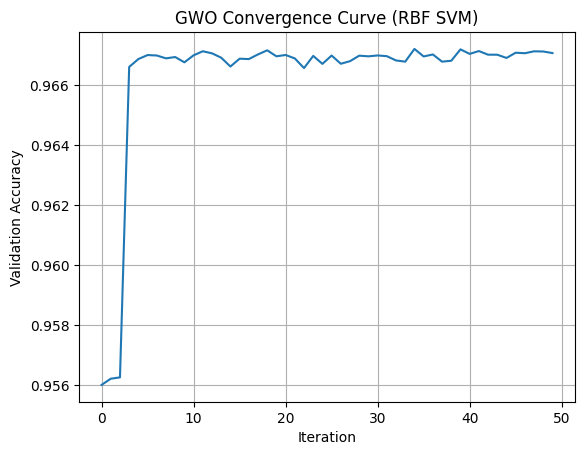

In [17]:
plt.plot(gwo.history)
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("GWO Convergence Curve (RBF SVM)")
plt.grid()
plt.show()